In [1]:
%matplotlib inline

import nengo
import tensorflow as tf
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
from nengo.utils.functions import piecewise
from math import sin
import random

In [2]:
with nengo.Network() as net:
    net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear()
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Uniform(-1, 1)
#     net.config[nengo.Connection].synapse = None
      
    c_sig = nengo.Node(
        piecewise({
            0: 1,
            1: 0.5,
            2: 0,
            3: -0.5,
            4: -1
        }))
    
    osc = nengo.Ensemble(n_neurons=500, dimensions=8)
    feedback = nengo.Ensemble(n_neurons=500, dimensions=6)
    output = nengo.Ensemble(n_neurons=50, dimensions=1)
    
    nengo.Connection(osc[0], feedback[0])
    nengo.Connection(osc[1], feedback[1])
    nengo.Connection(osc[2], feedback[2])
    
    nengo.Connection(feedback[3], osc[3])
    nengo.Connection(feedback[4], osc[4])
    nengo.Connection(feedback[5], osc[5])
    
    nengo.Connection(c_sig, osc[6])
    nengo.Connection(osc[7], output)
    
    signal_probe = nengo.Probe(c_sig)
    output_probe = nengo.Probe(output)

Building finished in 0:00:02.                                                                                         
Simulating finished in 0:00:03.                                                                                       


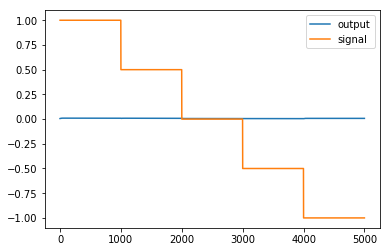

In [3]:
with nengo.Simulator(net) as sim:
    sim.run(5)
    plt.plot(sim.data[output_probe], label='output')
    plt.plot(sim.data[signal_probe], label='signal')
    plt.legend()

In [4]:
n_steps = 5000
n_inputs = 1
minibatch_size = 10

In [5]:
def test_osc(w, phase, step_size=0.001):
    return sin(w*step_size + phase), w*step_size + phase

def gen_test_data(batches, length, w_lower, w_upper):
    w_width = w_upper - w_lower
    input_data = np.zeros((batches, length*1000))
    output_data = np.zeros((batches, length*1000))
    for i in range(0, batches):
        data_dict = {}
        for k in range(0, length):
            data_dict[k] = random.random()*w_width + w_lower
        p_func = piecewise(data_dict)
        batch_in_data = np.array([p_func(x) for x in np.arange(0, length, 0.001)])
        batch_out_data = []
        phi = 0
        for w in batch_in_data:
            value, phi = test_osc(w, phi)
            batch_out_data.append(value)
        batch_out_data = np.array(batch_out_data)
        output_data[i] = batch_out_data
        input_data[i] = batch_in_data
    return np.reshape(input_data, (batches, length*1000, 1)), np.reshape(output_data, (batches, length*1000, 1))

In [6]:
with nengo_dl.Simulator(net, step_blocks=n_steps, minibatch_size=minibatch_size) as sim:
    test_in_feed, test_out_feed = gen_test_data(minibatch_size, int(n_steps/1000), -5, 5)
    input_feed, output_feed = gen_test_data(minibatch_size, int(n_steps/1000), -5, 5)
    
    sim.run_steps(n_steps, input_feeds={c_sig:test_in_feed})
    outputs = []
    outputs.append(sim.data[output_probe][0].flatten())
    for i in range(0, 3):
        sim.train({c_sig: input_feed},
                 {output_probe:output_feed},
                 tf.train.MomentumOptimizer(5e-3, 0.9), n_epochs=1)
        sim.soft_reset(include_probes=True)
        sim.run_steps(n_steps, input_feeds={c_sig:test_in_feed})
        outputs.append(sim.data[output_probe][0].flatten())

Building completed in 0:00:01 
Optimization completed in 0:00:00 
Construction completed in 0:00:00 
Simulation completed in 0:00:05
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:22
Simulation completed in 0:00:05
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:24
Simulation completed in 0:00:06
[##############################] ETA: 0:00:00 (Training)
Training completed in 0:00:23
Simulation completed in 0:00:05


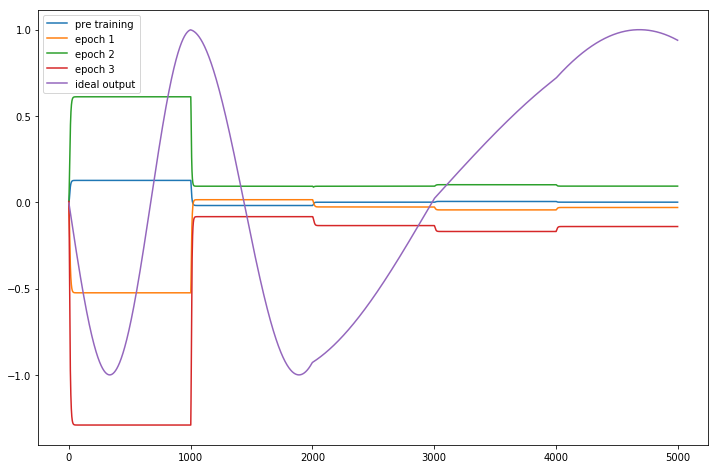

In [7]:
    plt.figure(num=None, figsize=(12,8),facecolor='w', edgecolor='k')
    plt.plot(outputs[0],  label='pre training')    
    plt.plot(outputs[1],  label='epoch 1')
    plt.plot(outputs[2],  label='epoch 2')
    plt.plot(outputs[3],  label='epoch 3')

    plt.plot(test_out_feed[0].flatten(), label='ideal output')
    plt.legend()
    